In [1]:
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
import numpy as np
import scipy.io as sio
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import tree
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
import random
from collections import Counter
np.random.seed(0)
random.seed(0)

# 





In [2]:

# cross-validation  with baseline include 0 class . accuracy =1- err  err=abs(y_pred-y_test)/3  

def valid(x,y,opt):
    if x.shape[1] == 15 :
        featureName=['VarBR','Varpp','VarIn','VarEx', 'meanBR',\
             'meanIn', 'meanEx' ,'r1 BR','r1 PP','r1 IN','r1 EX','r2 BR','r2 PP','r2 IN','r2 EX']
    if x.shape[1] == 18 :
        featureName=['CovBR','CovPP','CovIN','CovEX', 'meanBR',\
             'meanIN', 'meanEX' ,'r1 BR','r1 PP','r1 IN','r1 EX','r2 BR','r2 PP','r2 IN','r2 EX',\
            'meanHR','sdnn','rmsrr']
    thres=0.9
    acc=[]
    impt=[]
    scale=y[0,:]
    group=y[1,:]
    acc_max_temp=0  
    tree_max=[]
    a=opt[2]
    b=opt[3]
    ran=0
    if opt[0]=='kfold':
        rkf = RepeatedStratifiedKFold(n_splits=5, n_repeats=3,random_state=ran)

        
        for train_ind, test_ind in rkf.split(x,scale):
            #print("%s %s" % (train_ind, test_ind))
            #print(test_ind)
            X_train=x[train_ind] 
            X_test=x[test_ind]
            y_train=scale[train_ind] 
            y_test=scale[test_ind]
            
            acc_temp=np.zeros((8,))
            impt_temp=np.zeros((8,x.shape[1]))
            
            
            for i in range(8):
                if  opt[1]=='tree':
                    tree1 = DecisionTreeRegressor(max_depth=a,random_state=ran).fit(X_train,y_train)
                if  opt[1]=='forest':
                    tree1 = RandomForestRegressor(max_depth=b,n_estimators=40,max_features=None,random_state=ran).fit(X_train,y_train)

                y_p=tree1.predict(X_test)
                acc_t = 1-abs(y_p.astype('float')-y_test.astype('float'))/10
                
                acc_temp[i]=np.mean(acc_t)
                impt_temp[i,:]=tree1.feature_importances_
                if acc_temp[i] >= thres:
                    acc_max_temp=acc_temp[i]
                    tree_max.append(tree1)

            max=np.max(acc_temp)
            ind=np.where(acc_temp == np.amax(acc_temp))
            ind=np.min(ind)
            impt_max=impt_temp[ind,:]
            acc.append(max) 
            impt.append(impt_max)


    if opt[0]=='group':
        rkf = LeaveOneGroupOut()

        for train_ind, test_ind in rkf.split(x,scale,group):
            #print("%s %s" % (train_ind, test_ind))
            #print(test_ind)
            X_train=x[train_ind] 
            X_test=x[test_ind]
            y_train=scale[train_ind] 
            y_test=scale[test_ind]
            
            acc_temp=np.zeros((8,))
            impt_temp=np.zeros((8,x.shape[1]))
            
             
            for i in range(8):
                if  opt[1]=='tree':
                    tree1 = DecisionTreeRegressor(max_depth=a).fit(X_train,y_train)
                if  opt[1]=='forest':
                    tree1 = RandomForestRegressor(max_depth=b,n_estimators=40,max_features=None).fit(X_train,y_train)

                y_p=tree1.predict(X_test)
                acc_t = 1-abs(y_p.astype('float')-y_test.astype('float'))/10
                acc_temp[i]=np.mean(acc_t)
                impt_temp[i,:]=tree1.feature_importances_
                if acc_temp[i] >= thres:
                    acc_max_temp=acc_temp[i]
                    tree_max.append(tree1)

            max=np.max(acc_temp)
            ind=np.where(acc_temp == np.amax(acc_temp))
            ind=np.min(ind)
            impt_max=impt_temp[ind,:]
            acc.append(max) 
            impt.append(impt_max)

    impt=np.array(impt) 
    importance1=np.mean(impt,axis=0)
    seq=np.argsort(importance1)
    featureName=np.array(featureName)
    featureName1=featureName[seq]
    importance1=importance1[seq]
    importance1=np.flip(importance1)
    featureName1=np.flip(featureName1)
        
    acc=np.array(acc)
    acc_mean=np.mean(acc)
    print('{n:.3f}'.format(n=acc_mean))
    
    return acc,featureName1,importance1,tree_max,acc_mean

def test(X_test,y_test,tree):
    acc_temp=[]
    acc_max_temp=0
    for i in range(len(tree)):
        
        y_p=tree[i].predict(X_test)
        acc_t = 1-abs(y_p.astype('float')-y_test.astype('float'))/10
        
        acc_temp.append(np.mean(acc_t))
        if np.mean(acc_t) >= acc_max_temp:
            acc_max_temp=np.mean(acc_t)
            tree_max=tree[i]
            tree_max_ind=i       
            y=np.stack((y_test, y_p))
    print('{n:.3f}'.format(n=acc_max_temp))
    return acc_max_temp,y,tree_max_ind    #y = test + predict labels

def test_vote(X_test,y_test,tree):
    
    y_p_temp = np.zeros((X_test.shape[0],len(tree)))
    y_p=np.zeros((X_test.shape[0],))
    for i in range(len(tree)):
        y_p_temp[:,i]=tree[i].predict(X_test)

    
    y_p=np.mean(y_p_temp,axis=1)
      
        
    
    #acc = 1-abs(y_p.astype('int')-y_test.astype('int'))/10
    acc = 1-abs(y_p.astype('float')-y_test.astype('float'))/10
    acc=np.mean(acc)
    y_p=np.round(y_p,decimals=2)
    print('{n:.3f}'.format(n=acc))
    y=np.stack((y_test, y_p))
    return acc,y    #y = test + predict labels


In [4]:
score13_n=np.array([4, 9 ,2, 2 ,4 ,3, 6 ,9, 3, 2, 1, 4, 5 ,8, 3])
score15_n=np.array([9, 5 ,3 ,5, 4 ,2 ,8 ,3, 1, 1, 4, 1 ,3, 2])
score11=np.zeros((15,))
score_wo=np.hstack((score13_n,score15_n))
score=np.hstack((score13_n,score15_n,score11))
score2=np.hstack((score,score))
score2_wo=np.hstack((score_wo,score_wo))
score_feat=np.hstack((score11,score13_n,score15_n))
score2_feat=np.hstack((score_feat,score_feat))

#score_test=np.array([3,3,5,8,8,6,4,3])
score_test=np.array([3,3,5,8,8,6,4,3,0,0,0])
score2_test=np.hstack((score_test,score_test))


In [13]:

# 18 features include ECG  include NCS and chest belt 
# generate the best decision tree with highest accuracy & calculate mean accuracy
data = sio.loadmat(r"C:\Sleep test\dyspnea\data\all\data_norm.mat")
delta_norm = data['delta2']
#scale_norm = data['scale2_n'].ravel()

group_norm = data['group_norm'].ravel()
#y1=np.stack((scale_norm, group_norm))
y1=np.stack((score2, group_norm))
opt=['group','forest',8,8]





data = sio.loadmat(r"C:\Sleep test\dyspnea\data\all\data_testNew.mat")
#data = sio.loadmat(r"C:\Sleep test\dyspnea\data\all\data_test.mat")
delta_Ncs_test = data['deltaNcs']
delta_Bio_test = data['deltaBio']
delta2_test=np.concatenate((delta_Ncs_test, delta_Bio_test),axis=0)



In [6]:
data = sio.loadmat(r"C:\Sleep test\dyspnea\data\all\data_Ncs_norm.mat")
delta_norm = data['deltaNcs']
delta_norm_bio = data['deltaBio']
#scale_norm = data['scale_n'].ravel()
group_norm = data['group_norm'].ravel()
#y1=np.stack((scale_norm, group_norm))
y1=np.stack((score, group_norm))







In [12]:
# artificially add extrem cases (5*2) to training set
data = sio.loadmat(r"C:\Sleep test\dyspnea\data\all\data_extreme_train.mat")
#data = sio.loadmat(r"C:\Sleep test\dyspnea\data\all\data_test.mat")
delta_Ncs_extreme = data['deltaNcs']
delta_Bio_extreme = data['deltaBio']
delta2_extreme=np.concatenate((delta_Ncs_extreme, delta_Bio_extreme),axis=0)
score_extreme=np.array([10,10,10,10,10,10,10,10,10,10])
score2_extreme=np.hstack((score_extreme,score_extreme))
group_extreme=np.array([2,2,3,3,4,4,5,5,6,6])
group2_extreme=np.hstack((group_extreme,group_extreme))
delta_norm_extreme=np.vstack([delta_norm,delta_Ncs_extreme[:,0:15]])
delta_norm_extreme_bio=np.vstack([delta_norm_bio,delta_Bio_extreme[:,0:15]])
opt=['kfold','tree',3,3]
#opt=['kfold','forest',3,3]
y1=np.block([[score,score_extreme],[group_norm,group_extreme]])

acc2,featureName2,importance2,tree2,accMean2=valid(delta_norm_extreme,y1,opt)
acc3,featureName3,importance3,tree3,accMean3=valid(delta_norm_extreme_bio,y1,opt)





data = sio.loadmat(r"C:\Sleep test\dyspnea\data\all\data_test_with0_10.mat")
#data = sio.loadmat(r"C:\Sleep test\dyspnea\data\all\data_test.mat")
delta_Ncs_test = data['deltaNcs']
delta_Bio_test = data['deltaBio']
score_test=data['score_n'].ravel()
acc,label1=test_vote(delta_Ncs_test[:,0:15],score_test,tree2)
acc,label1=test_vote(delta_Bio_test[:,0:15],score_test,tree3)




0.844
0.845
0.771
0.818


acc1_mean=0.892
FeatureImportance1:
r1 EX=0.401
sdnn=0.155
r2 BR=0.147
r2 EX=0.098
acc2_mean=0.87
FeatureImportance2:
r2 BR=0.378
r1 EX=0.184
r2 EX=0.106
r2 PP=0.085
acc3_mean=0.86
FeatureImportance3:
r2 BR=0.424
r1 EX=0.172
r2 EX=0.106
r2 PP=0.070


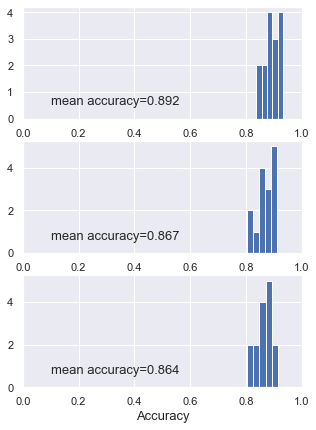

In [181]:
import matplotlib.pyplot as plt
import seaborn as sns


sns.set(rc={"figure.figsize": (8, 15)}); np.random.seed(0)
size=13
s01='acc1_mean={n:.3f}\nFeatureImportance1:\n{n1}={s1:.3f}\n{n2}={s2:.3f}\n{n3}={s3:.3f}\n{n4}={s4:.3f}'.format(n=accMean1,n1=featureName1[0],s1=importance1[0],
    n2=featureName1[1],s2=importance1[1],n3=featureName1[2],s3=importance1[2],n4=featureName1[3],s4=importance1[3])
s02='acc2_mean={n:.2f}\nFeatureImportance2:\n{n1}={s1:.3f}\n{n2}={s2:.3f}\n{n3}={s3:.3f}\n{n4}={s4:.3f}'.format(n=accMean2,n1=featureName2[0],s1=importance2[0],
    n2=featureName2[1],s2=importance2[1],n3=featureName2[2],s3=importance3[2],n4=featureName3[3],s4=importance2[3])
s03='acc3_mean={n:.2f}\nFeatureImportance3:\n{n1}={s1:.3f}\n{n2}={s2:.3f}\n{n3}={s3:.3f}\n{n4}={s4:.3f}'.format(n=accMean3,n1=featureName3[0],s1=importance3[0],
    n2=featureName3[1],s2=importance3[1],n3=featureName3[2],s3=importance3[2],n4=featureName3[3],s4=importance3[3])
s1='mean accuracy={n:.3f}\n'.format(n=accMean1)
s2='mean accuracy={n:.3f}\n'.format(n=accMean2)
s3='mean accuracy={n:.3f}\n'.format(n=accMean3)

plt.figure(figsize=(5,7))
plt.subplot(3,1,1)
plt.hist(acc1, bins=5,density=False)
plt.xlim((0, 1))
plt.text(0.1,0,s1,fontsize=size)
plt.subplot(3,1,2)
plt.hist(acc2, bins=5, density=False)
plt.xlim((0, 1))
plt.xlabel('Accuracy',fontsize=size)
plt.text(0.1,0,s2,fontsize=size)
plt.subplot(3,1,3)
plt.hist(acc3, bins=5, density=False)
plt.xlim((0, 1))
plt.xlabel('Accuracy',fontsize=size)
plt.text(0.1,0,s3,fontsize=size)


#plt.savefig(r"C:\Sleep test\dyspnea\figure\acc_kfold3.png",dpi=600)
print(s01)
print(s02)
print(s03)
#from scipy.io import savemat

#mdic = {"a": a, "label": "experiment"}
#savemat(r"C:\Sleep test\dyspnea\data\all\plot\acc_kfold.png", mdic)